# ROMS in Python - Analyses: MKE and EKE

by David Gwyther

This notebook will focus on MKE and EKE analyses

In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/local/m68/deg581/tmp'

In [2]:
# cartopy load the coast:

import cartopy.feature as cfeature

def loadCartopyCoast():
    Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',
                                    facecolor='none', name='coastline')
    return Coast

Coast = loadCartopyCoast()


In [3]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [4]:
print(client)

<Client: 'tcp://10.0.128.139:46153' processes=0 threads=0, memory=0 B>


## load data

In [5]:
# load multiple ROMS netcdf with xr


# filelist = glob.glob('/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_0800*.nc')
# chunks = chunks={'ocean_time':1}
# def RemoveSomeDays(ds):
#     '''remove the last 7 timesteps from each file'''
#     return ds.isel(ocean_time = slice(0,-7))

# ds = xr.open_mfdataset(filelist,chunks, preprocess=RemoveSomeDays, data_vars='minimal', compat='override', coords='minimal', parallel=False, join='right')
# ds

# note that I turned off parallel - was finding it was freezing with dask?
# alternative: load once, chop off vars and save to a processed netcdf, then load with:

ds = xr.open_dataset('/g/data/fu5/deg581/OSSE_analysis/data/proc/output_truth_8005_8401.nc')
ds

<xarray.Dataset>
Dimensions:        (s_rho: 30, s_w: 31, tracer: 2, boundary: 4, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 80)
Coordinates: (12/14)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    z_rho0         (eta_rho, xi_rho, s_rho) float64 ...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/102)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 ...
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 ...
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 ...
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 ...
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 ...
    dA             (eta_rho, xi_rho) float64 ...
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## let's first process our dataset and make a grid file

In [6]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

# if loading a multi-file dataset, then process the grid with this.
# ds = processROMSGrid(ds)

grid = makeROMSGridObject(ds)

In [9]:
# drop some variables to speed up loading!
ds = ds[['u_eastward','v_northward','z_rho0']]
ds = ds.drop(['z_rho'])

# Let's load the u,v velocities to speed this up...
ds.load()


<xarray.Dataset>
Dimensions:      (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
Coordinates:
    z_rho0       (eta_rho, xi_rho, s_rho) float64 nan nan nan ... -4.483 -1.035
  * s_rho        (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho      (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
    lat_rho      (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
  * ocean_time   (ocean_time) datetime64[ns] 2011-12-02 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 0.0
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

## calculate MKE
MKE is calculated as the mean in kinetic energy over the 'longer term'... which is a bit ambiguous, but probably needs to be significantly longer than the mesoscale. So maybe a year at least?

In [17]:
u_bar = ds.u_eastward.mean("ocean_time")
v_bar = ds.v_northward.mean("ocean_time")
mke = 0.5*(u_bar**2 + v_bar**2)

ds["mke"] = mke

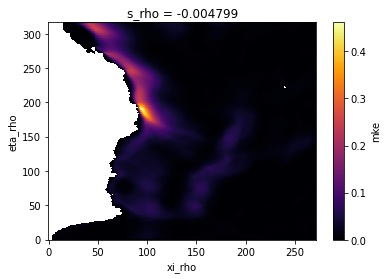

In [18]:
ds.mke.isel(s_rho=-1).plot(cmap='inferno')

In [19]:

u_bar = ds.u_eastward.mean("ocean_time")
v_bar = ds.v_northward.mean("ocean_time")

print('calc velocity anomalies')
u_prime = ds.u_eastward - u_bar
v_prime = ds.v_northward - v_bar

print('calc eke')
eke = 0.5*(u_prime**2 + v_prime**2)

ds["eke"] = eke

calc velocity anomalies
calc eke


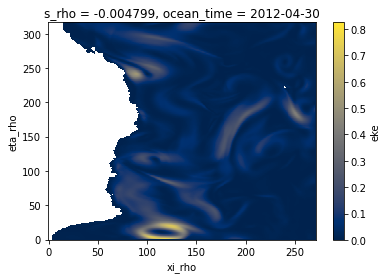

In [20]:
ds.eke.isel(s_rho=-1).isel(ocean_time=30).plot(cmap='cividis')

In [21]:
# Or define a function, like this:

def calc_EKE(input):
    
    print('calculate time mean velocities')
    u_eastward = input.u_eastward
    v_northward = input.v_northward
    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")
    
    print('calc velocity anomalies')
    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar
    
    print('calc mke')
    mke = 0.5*(u_bar**2 + v_bar**2)
    
    print('calc eke')
    eke = 0.5*(u_prime**2 + v_prime**2)

    return mke,eke


<Figure size 432x288 with 0 Axes>

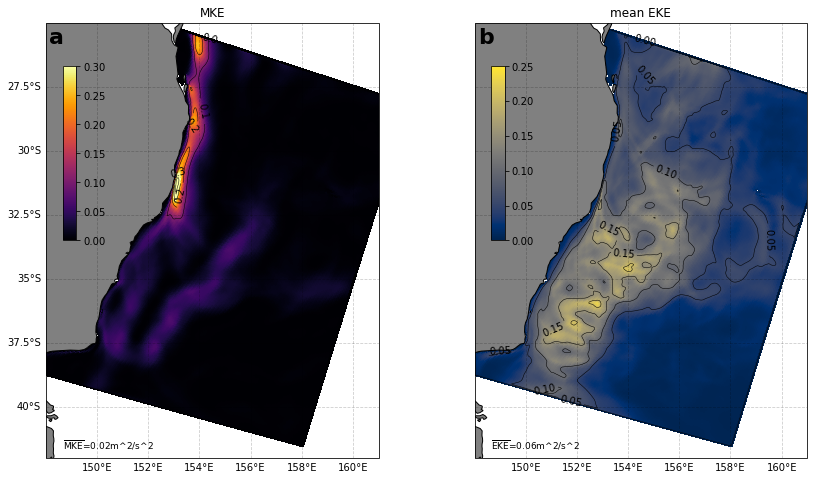

In [41]:
# let's plot this up

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),vmin=0,vmax=.3,cmap='inferno')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),colors='k',levels=np.arange(0,.6,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('MKE')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .03,  '$\overline{\mathrm{MKE}}$='+str(grid.average((ds.mke.isel(s_rho=-1)),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)
cax = inset_axes(ax,
             width="5%",  # width = 10% of parent_bbox width
             height="50%",  # height : 50%
             loc='lower left',
             bbox_to_anchor=(.05,.50, .8, .8),
             bbox_transform=ax.transAxes,
             borderpad=0,
             )
fig.colorbar(im, cax=cax)

ax=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-1).mean(dim='ocean_time'),vmin=0,vmax=.25,cmap='cividis')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-1).mean(dim='ocean_time'),colors='k',levels=np.arange(0,.3,.05),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('mean EKE')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .03,  '$\overline{\mathrm{EKE}}$='+str(grid.average((ds.eke.isel(s_rho=-1).mean(dim='ocean_time')),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)
cax = inset_axes(ax,
             width="5%",  # width = 10% of parent_bbox width
             height="50%",  # height : 50%
             loc='lower left',
             bbox_to_anchor=(.05,.50, .8, .8),
             bbox_transform=ax.transAxes,
             borderpad=0,
             )
fig.colorbar(im, cax=cax)